In [ ]:
#immediate TODO 's:
# appropriate piping in of modes for simulation (Popoff) + analysis of such
# (ask Gert for other TODO 's discussed 5/28/25?) - esp if running out later on
# --> calibration of input modes for desired single output mode (TM)
# simulation of bending (either Popoff or some model of how some fiber *physically bends* that we use to form the fiber shape

#long-term TODO 's
# longer fiber simulation
# graded-index (if time)

#DONEs:
# Special bound conditions where the real extends into the boundaries (treat fiber as infinite)
# Make sure long absorbing boundary at other side (very little power)
# Make sure beam source is not within boundary

In [57]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt

from chromatix.experimental.modified_born_series.sample import (
    EmptySample,
    Source,
    add_absorbing_bc,
)
from chromatix.experimental.modified_born_series.solver import solve

%config InlineBackend.figure_format='retina'

## Step-index fiber (single-refr for core and cladding)

In [128]:
infinite_fiber = True

wavelength = 0.625  # 0.5  # [mum]
material_core_refractive_index = 1.5
material_cladding_refractive_index = 1.4
n_background = 1.0
k0 = 2 * jnp.pi / wavelength
# grid_shape = [256, 256 * 4 // 3, 8]
grid_shape = [64, 128, 64]
spacing = wavelength / 2
mbs_thickness = 10.0 * wavelength
mbs_boundary_width = int(mbs_thickness / spacing)

material_cylinder_refr_diff_arr = [0.1, 0.4]
material_cylinder_radius_arr = [0.5, 1]

# Definining sample
sample = EmptySample(grid_shape, spacing)
refractive_index = sample.permittivity  # 0.0 at start
print("Pre-pad sample shape (x, y, z):")
print(sample.shape)

for i in range(len(material_cylinder_refr_diff_arr)):
    # dn = material_core_refractive_index - n_background
    object_radius = (sample.extent[0] / 2) / 2 * material_cylinder_radius_arr[i]
    object = (
        jnp.sqrt((sample.grid[..., 0] ** 2) + (sample.grid[..., 2] ** 2))
        < object_radius
    )
    # refractive_index = 1.0 + dn * object
    refractive_index += material_cylinder_refr_diff_arr[i] * object
refractive_index += n_background
sample = sample.replace(permittivity=refractive_index**2)

no_pad = False  # set at axis 1
# Add absorbing boundaries
# sample = add_absorbing_bc(sample, axis=(0, 1), thickness=2.0, max_extinction=0.25)
sample = add_absorbing_bc(
    sample, axis=(1), thickness=mbs_thickness, max_extinction=0.25
)
print(jnp.max(sample.permittivity.imag))
permittivity_imag = 1.0j * sample.permittivity.imag.astype("complex64")
print(permittivity_imag.shape)
print(sample.permittivity.shape)


## Update absorbing boundaries to match expectations with fiber (add real portion to bounds)

if infinite_fiber:
    grid_shape2 = sample.permittivity.shape
    sample_dummy = sample = EmptySample(grid_shape2, spacing)
    refractive_index2 = sample_dummy.permittivity
    for i in range(len(material_cylinder_refr_diff_arr)):
        # dn = material_core_refractive_index - n_background
        object_radius = (sample.extent[0] / 2) / 2 * material_cylinder_radius_arr[i]
        object = (
            jnp.sqrt((sample.grid[..., 0] ** 2) + (sample.grid[..., 2] ** 2))
            < object_radius
        )
        # refractive_index = 1.0 + dn * object
        refractive_index2 += material_cylinder_refr_diff_arr[i] * object
    refractive_index2 += n_background
    print(jnp.max(sample.permittivity.imag))

    permittivity_real = (refractive_index2**2).astype("complex64")
    permittivity2 = permittivity_imag + permittivity_real
    # print(permittivity_imag)
    sample = sample.replace(permittivity=permittivity2)


print("Post-pad sample shape (x, y, z):")
sample.shape

print("Core radius (px, um):")
print(
    str(material_cylinder_radius_arr[0] * object_radius)
    + " (px), "
    + str(material_cylinder_radius_arr[0] * object_radius * spacing)[:6]
)
print("Cladding radius (um):")
print(str(material_cylinder_radius_arr[1] * object_radius * spacing)[:6])

Pre-pad sample shape (x, y, z):
(64, 128, 64)
0.5
(64, 168, 64)
(64, 168, 64)
0.0
Post-pad sample shape (x, y, z):
Core radius (px, um):
2.5 (px), 0.7812
Cladding radius (um):
1.5625


## 'Continuous' version

In [60]:
if False:
    wavelength = 0.5  # [mum]

    k0 = 2 * jnp.pi / wavelength
    # grid_shape = [256, 256 * 4 // 3, 8]
    grid_shape = [64, 128, 64]
    spacing = wavelength / 2

    # --------
    m_core_refr = 1.5
    m_cladding_refr = 1.4
    m_core_radius_ratio = 0.1

    background_refr = 1.0

    num_steps = 2
    m_cylinder_refr_diff_arr = [
        (m_core_refr - m_cladding_refr) / num_steps
    ] * num_steps  # [0.1, 0.4]
    m_cylinder_refr_diff_arr[-1] = m_cladding_refr - background_refr
    m_cylinder_radius_arr = jnp.linspace(
        m_core_radius_ratio, 1.0, num_steps
    )  # [0.5, 1]

    # Definining sample
    sample = EmptySample(grid_shape, spacing)
    refractive_index = sample.permittivity  # 0.0 at start
    print(sample.grid.shape)

    for i in range(len(m_cylinder_refr_diff_arr)):
        # dn = material_core_refractive_index - n_background
        object_radius = (sample.extent[0] / 2) / 2 * m_cylinder_refr_diff_arr[i]
        object = (
            jnp.sqrt((sample.grid[..., 0] ** 2) + (sample.grid[..., 2] ** 2))
            < object_radius
        )
        # refractive_index = 1.0 + dn * object
        refractive_index += m_cylinder_refr_diff_arr[i] * object
    refractive_index += background_refr
    print(jnp.max(refractive_index))
    sample = sample.replace(permittivity=refractive_index**2)

    no_pad = False  # set at axis 1
    # Add absorbing boundaries
    # sample = add_absorbing_bc(sample, axis=(0, 1), thickness=2.0, max_extinction=0.25)
    sample = add_absorbing_bc(sample, axis=(1), thickness=2.0, max_extinction=0.25)

    sample.shape

## Show sample permittivity

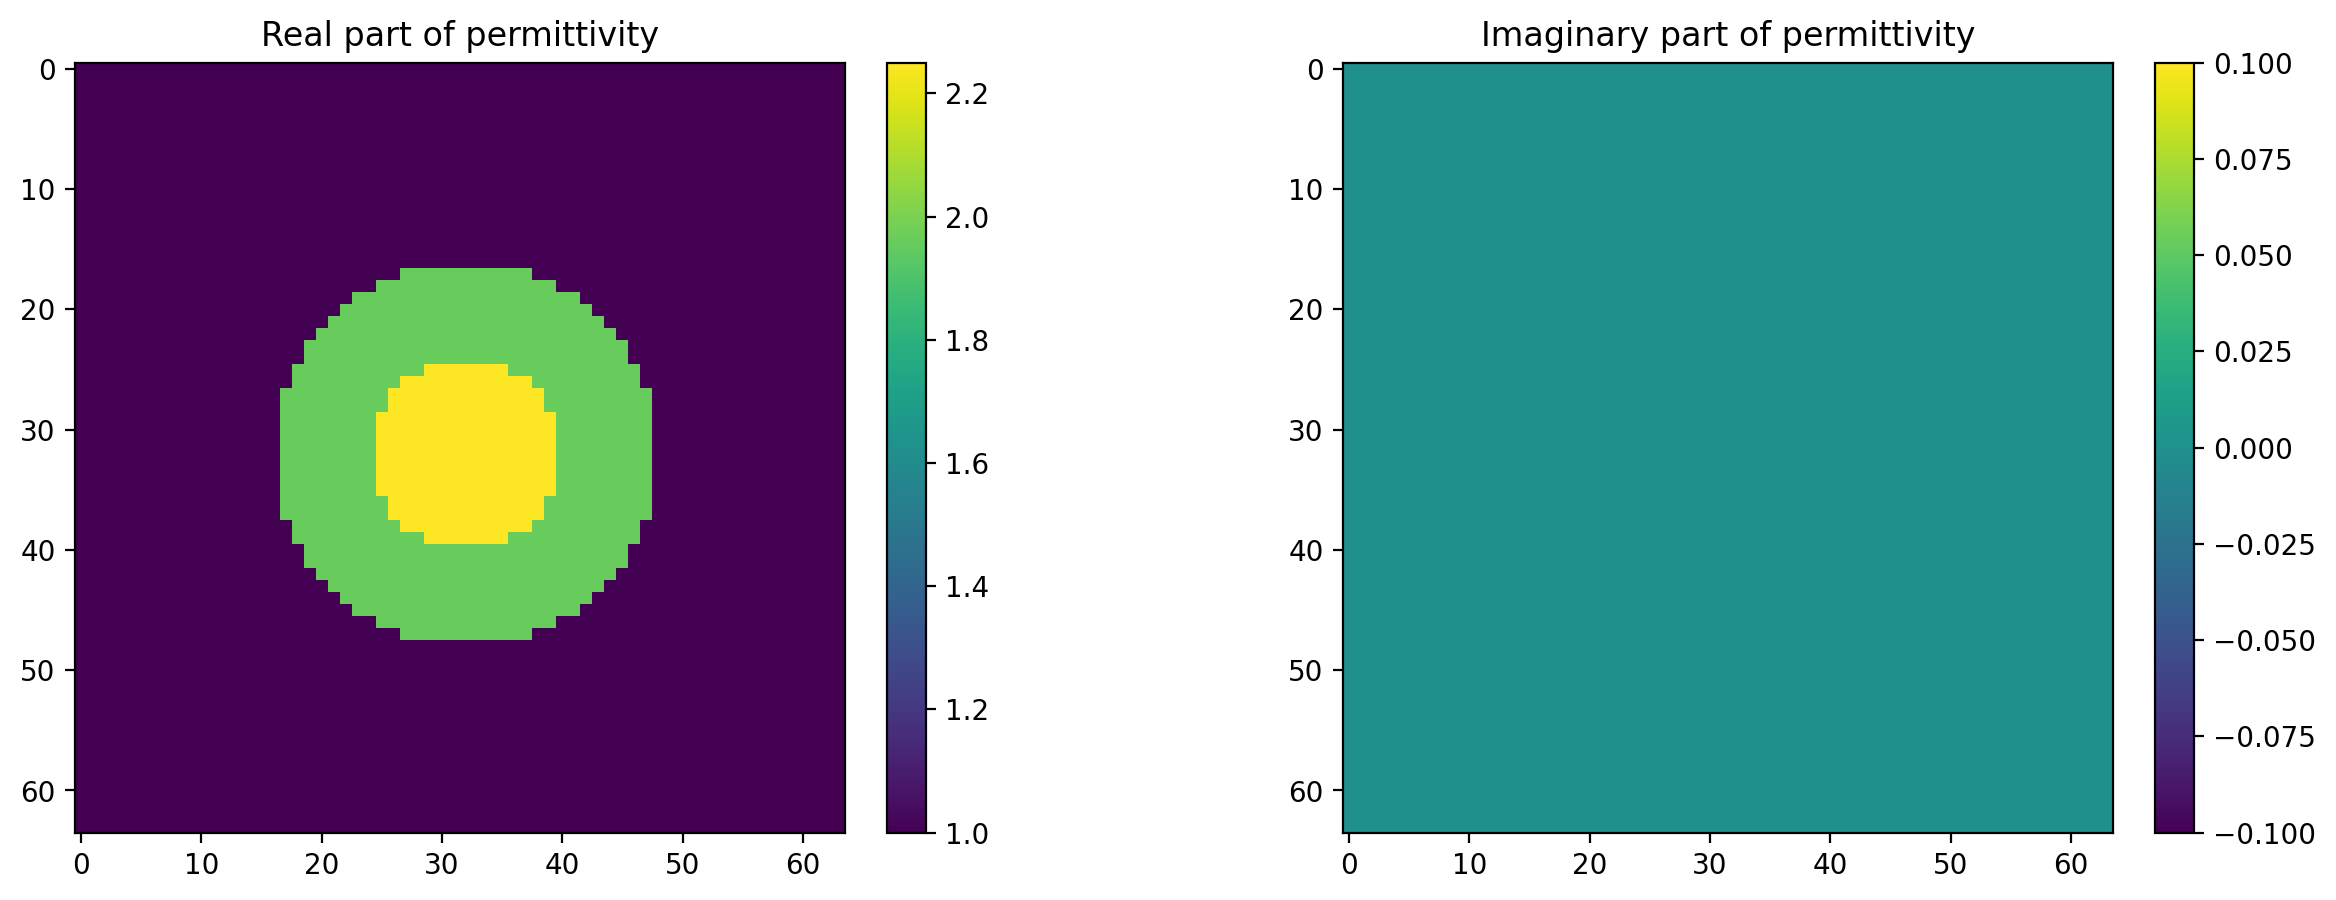

In [131]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(sample.permittivity[:, grid_shape[1] // 2, :].real)

plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(sample.permittivity[:, grid_shape[1] // 2, :].imag)

plt.colorbar(fraction=0.046, pad=0.04)
#TODO anti-alias (upscale factor of 3 in each direction, try einops -> mean filter, downsample factor 3 via said mean filter)
# currently staircase artifact

In [62]:
print(sample.permittivity.shape)
print(sample.shape)
print(grid_shape)
print(object.shape)

(64, 168, 64)
(64, 168, 64)
[64, 128, 64]
(64, 128, 64)


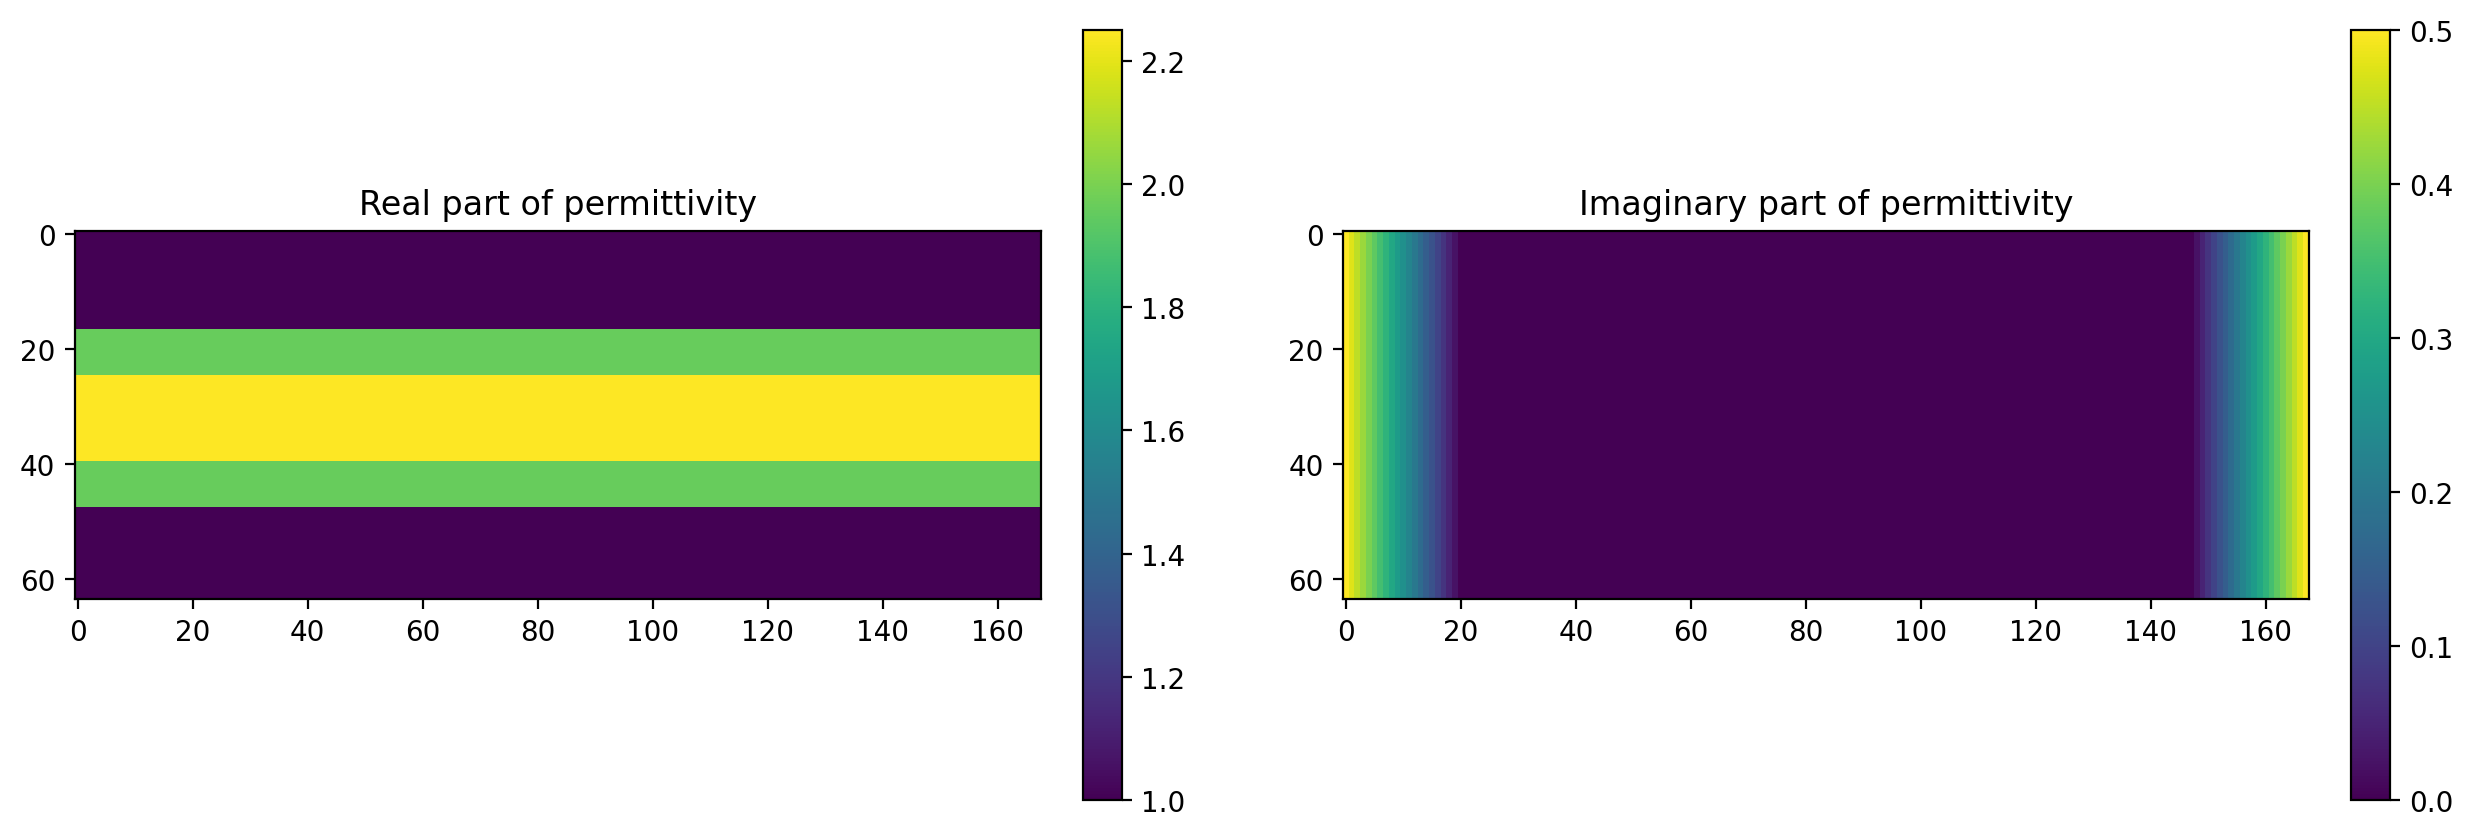

In [132]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(sample.permittivity[grid_shape[0] // 2, :, :].T.real)

plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(sample.permittivity[grid_shape[0] // 2, :, :].T.imag)

plt.colorbar(fraction=0.046, pad=0.04)

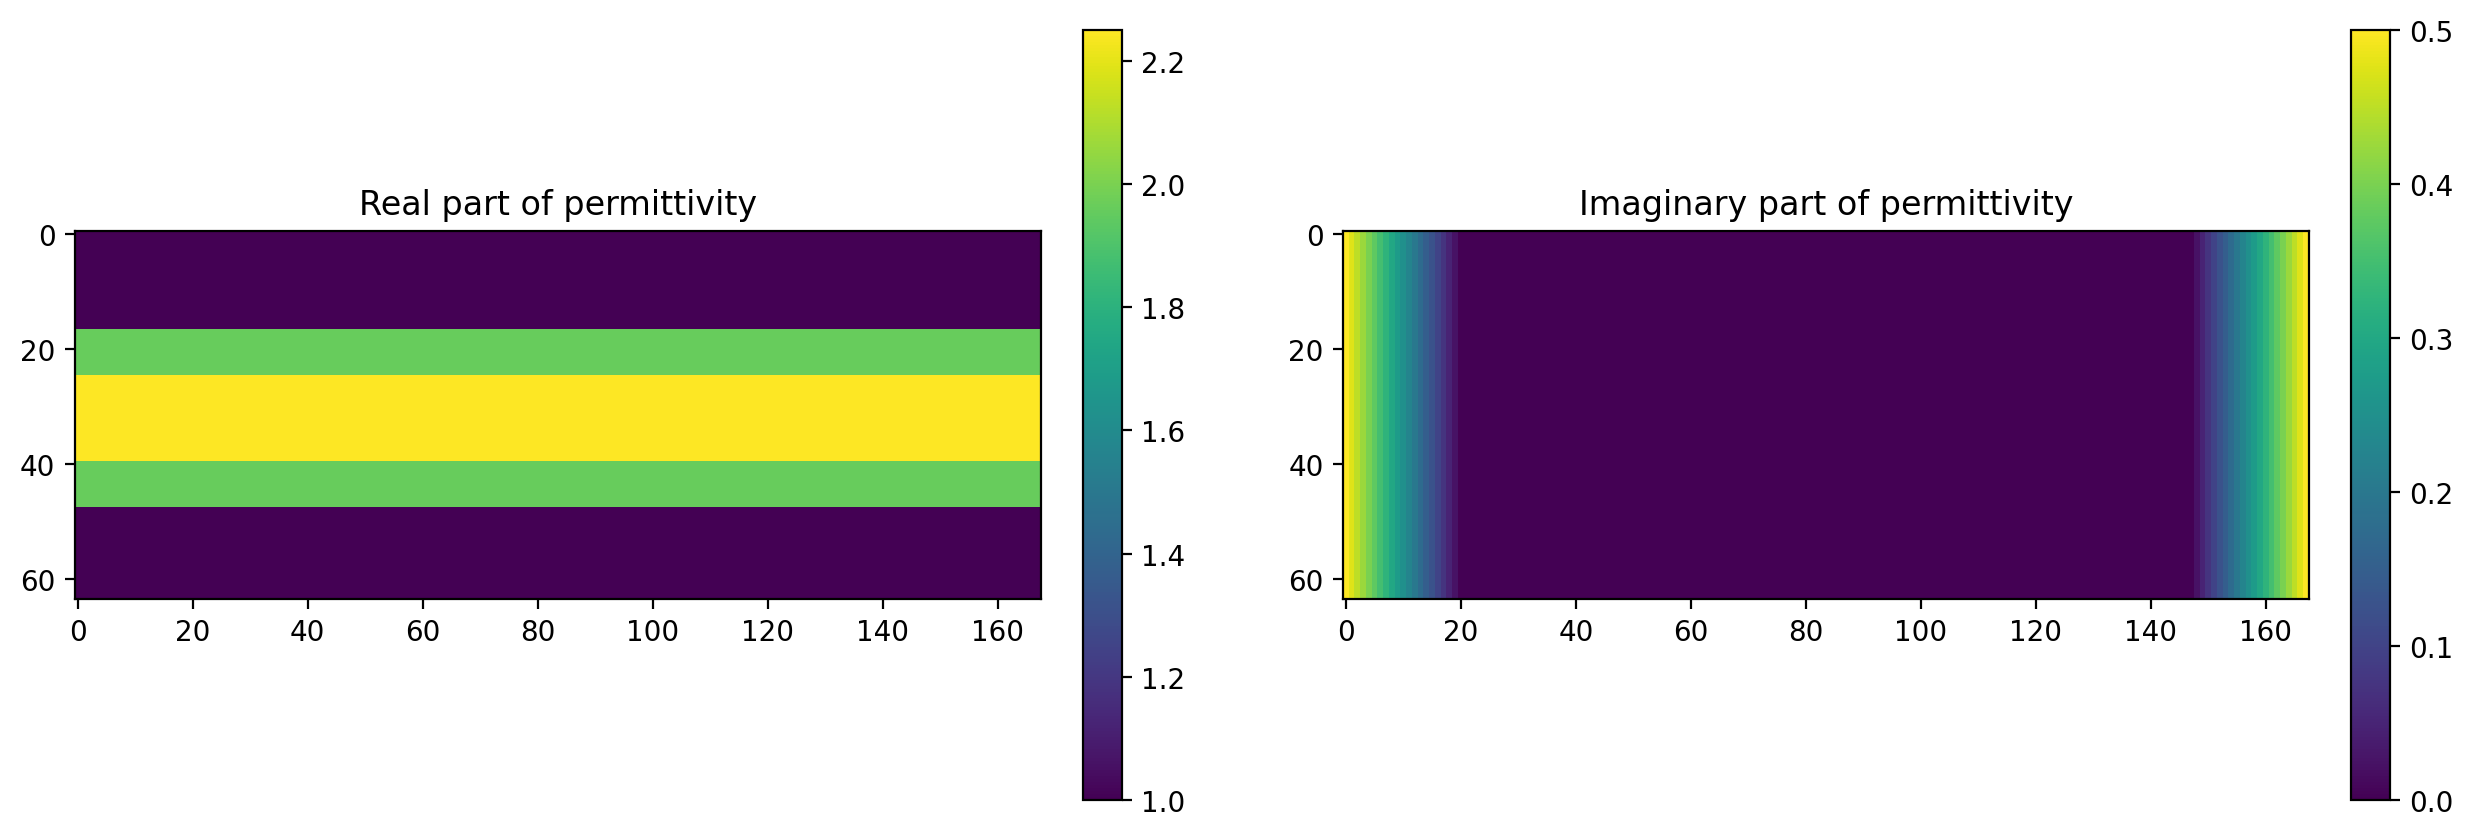

In [121]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(sample.permittivity[grid_shape[0] // 2, :, :].T.real)

plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(sample.permittivity[grid_shape[0] // 2, :, :].T.imag)

plt.colorbar(fraction=0.046, pad=0.04)

Text(0.5, 0.98, 'cross-section at relevant index (26)')

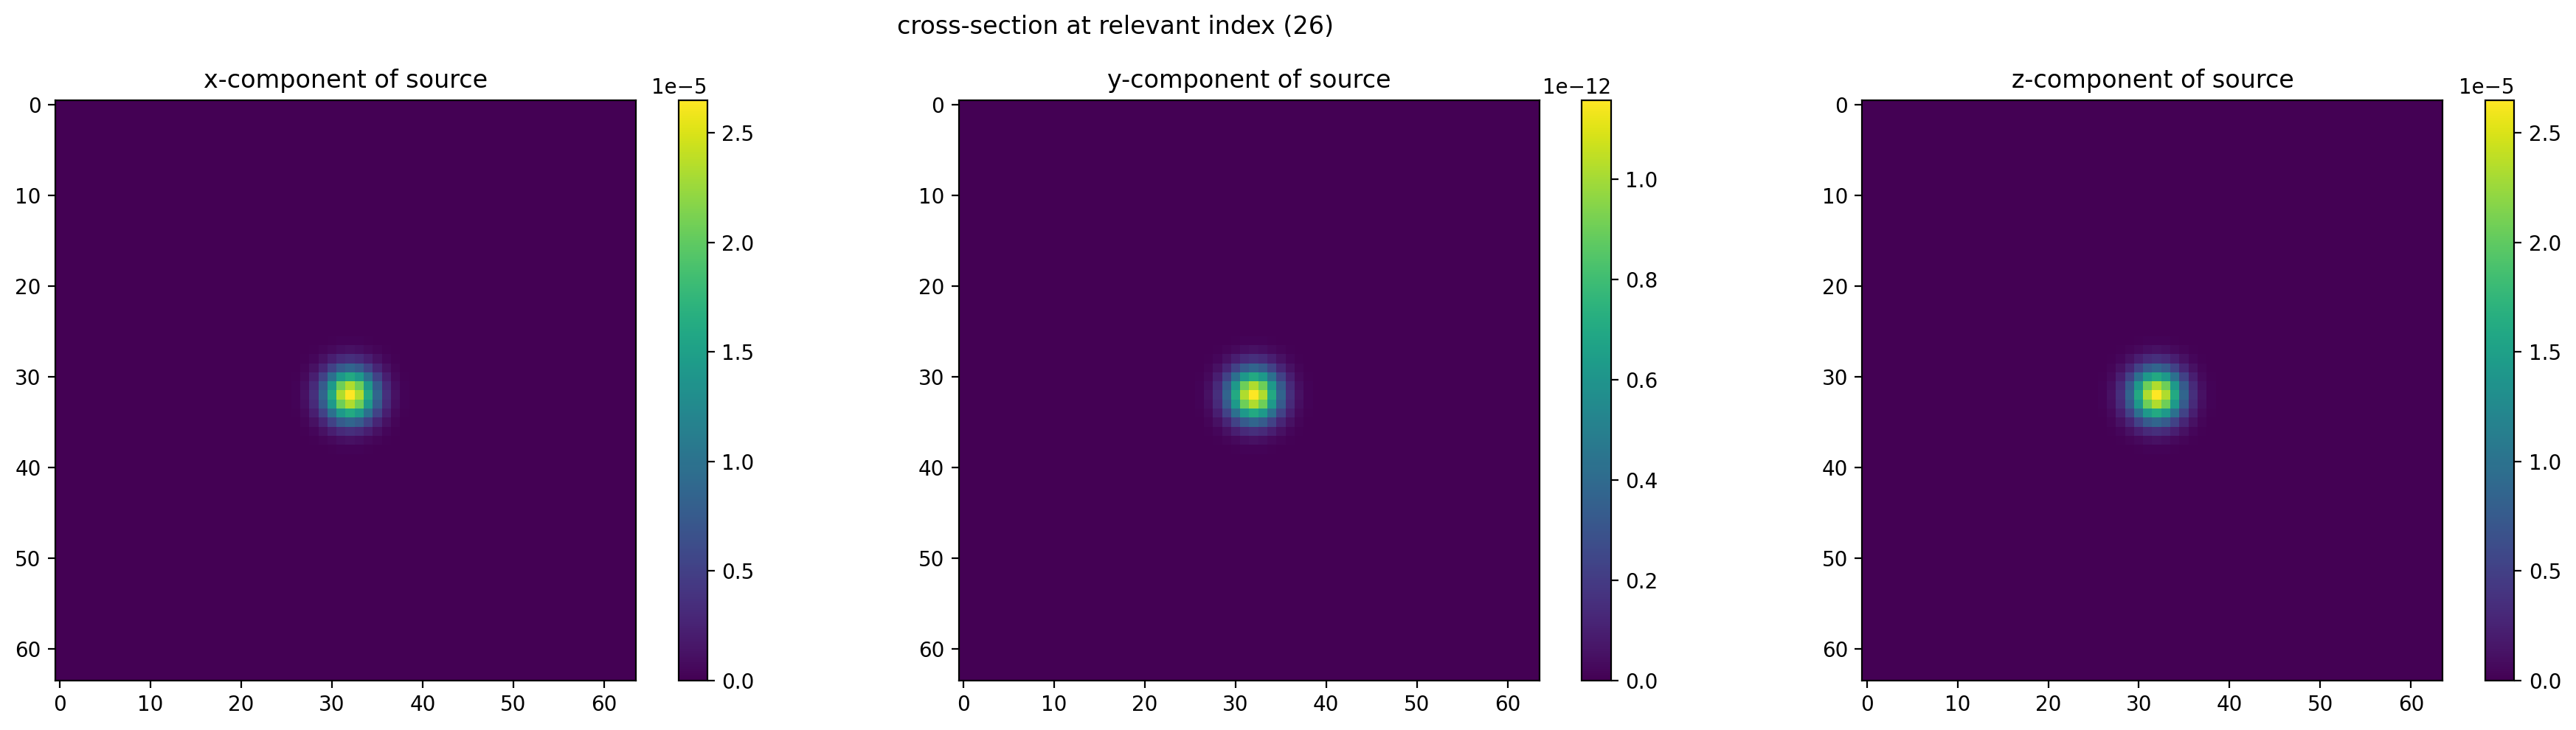

In [122]:
# Making the source
incident_angle = 1.0 / 2.0 * jnp.pi


def rot_Z(a):
    return jnp.array(
        [[jnp.cos(a), -jnp.sin(a), 0], [jnp.sin(a), jnp.cos(a), 0], [0, 0, 1]]
    )


incident_k = rot_Z(incident_angle) * k0 @ jnp.array([1, 0, 0])
source_polarization = rot_Z(incident_angle) @ jnp.array([0, 1, 1j]) / jnp.sqrt(2)

# Current density
beam_radius = (sample.extent[0] / 16) / 2
source_pixel_index = int(2.0 / sample.spacing) + mbs_boundary_width
grid = sample.grid[:, source_pixel_index]

current_density = jnp.exp(
    1j * jnp.sum(grid * incident_k, axis=-1)
)  # x z -- want z only
current_density = current_density * jnp.exp(
    # -0.5 * ((grid[..., 0] - object_radius/2.0) / beam_radius) ** 2
    -0.5 * (jnp.sqrt(grid[..., 0] ** 2 + grid[..., 2] ** 2) / beam_radius) ** 2
)
current_density = source_polarization * current_density[..., None]
current_density = (
    jnp.zeros((*sample.shape, 3), dtype=jnp.complex64)
    .at[:, source_pixel_index]
    .set(current_density)
)
source = Source(current_density, k0)


plt.figure(figsize=(20, 5), layout="tight")
plt.subplot(131)
plt.title("x-component of source")
plt.imshow(jnp.abs(source.field[:, source_pixel_index, :, 0]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("y-component of source")
plt.imshow(jnp.abs(source.field[:, source_pixel_index, :, 1]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("z-component of source")
plt.imshow(jnp.abs(source.field[:, source_pixel_index, :, 2]))
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle("cross-section at relevant index (" + str(source_pixel_index) + ")")

In [140]:
jnp.save("test", E)

In [123]:
# Actually solving
E = eqx.filter_jit(solve)(sample, source)
E = E[sample.ROI]  # extract ROI, we don't care about boundaries

Text(0.5, 0.98, "Central slice of fiber, cropped to cladding and pixel after source's plane")

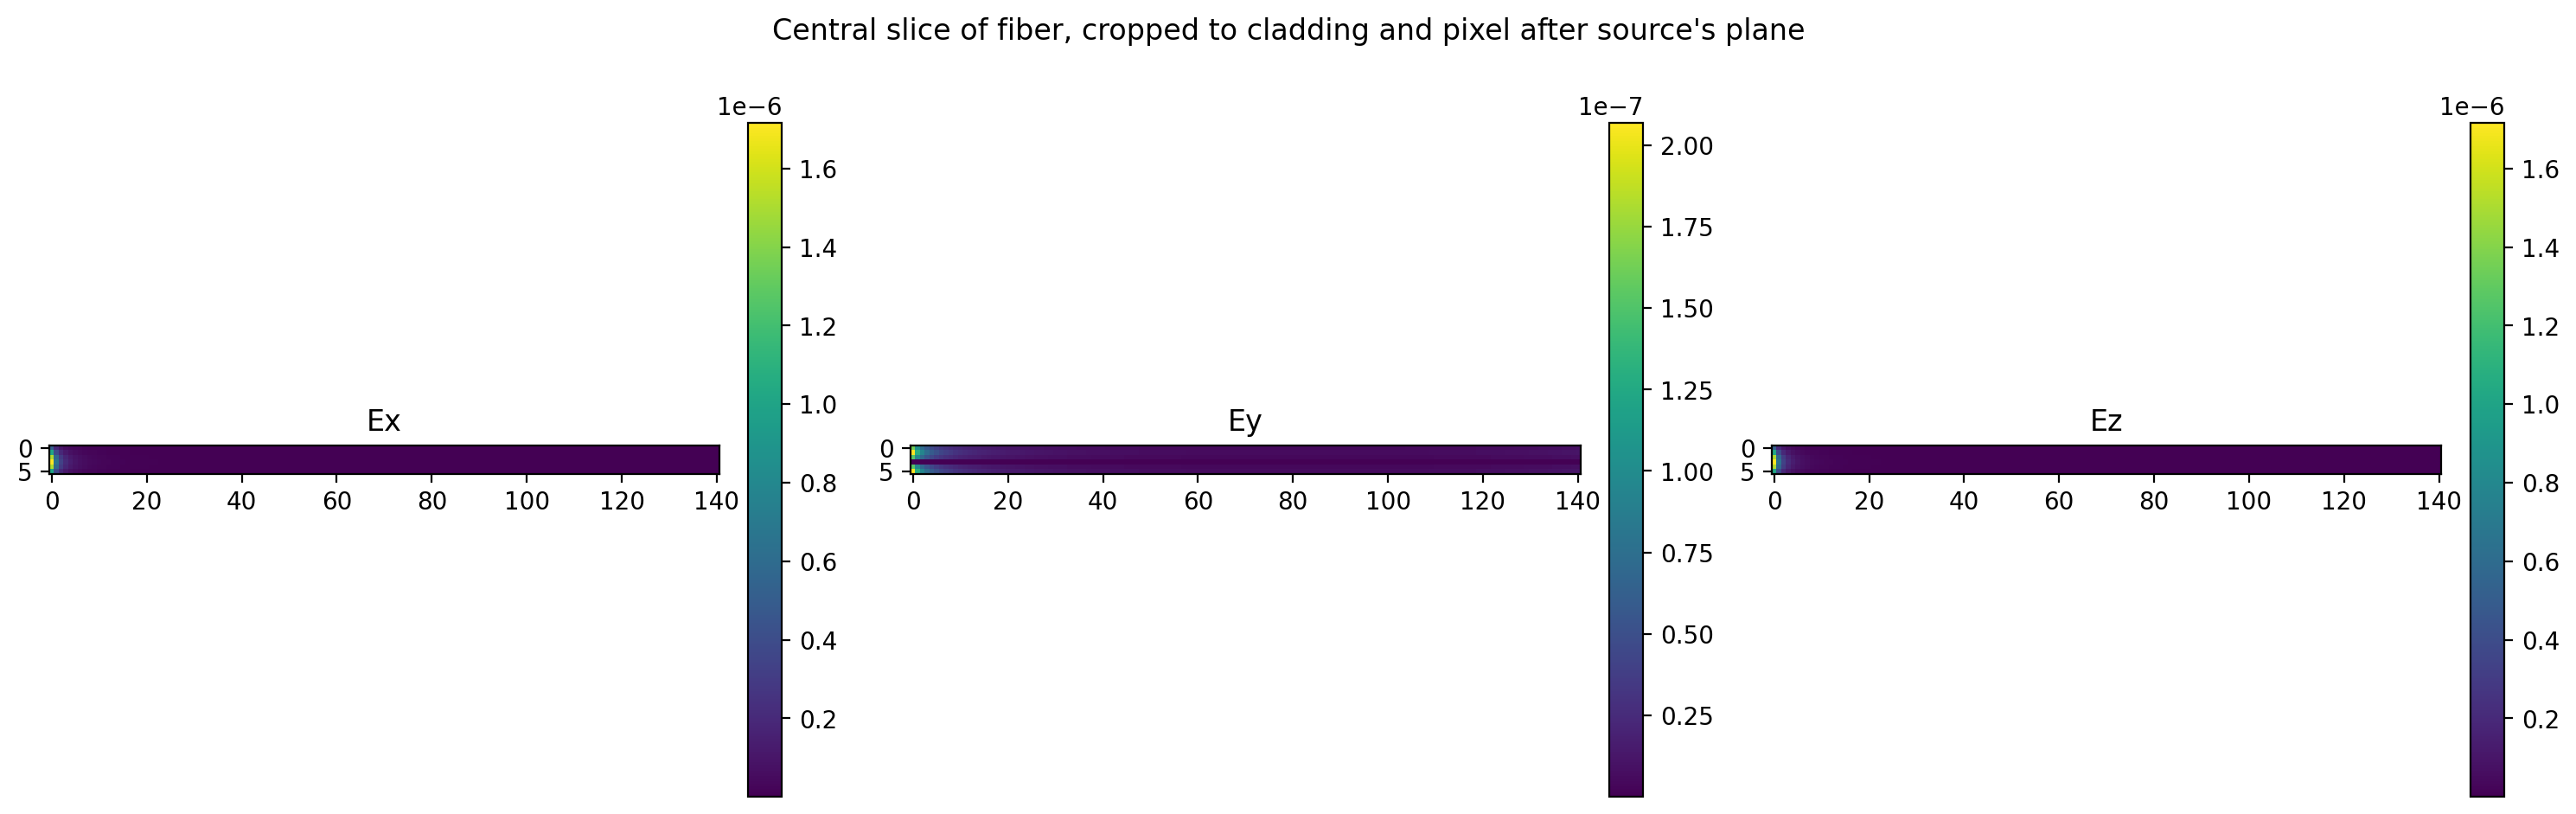

In [124]:
plt.figure(figsize=(15, 5), layout="tight")
hw = int(jnp.ceil(material_cylinder_radius_arr[0] * (sample.extent[0] / 2) / 2))


plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        0,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        1,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        2,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle(
    "Central slice of fiber, cropped to cladding and pixel after source's plane"
)

Text(0.5, 0.98, "Central slice of fiber, cropped to core and pixel after source's plane, log-scale")

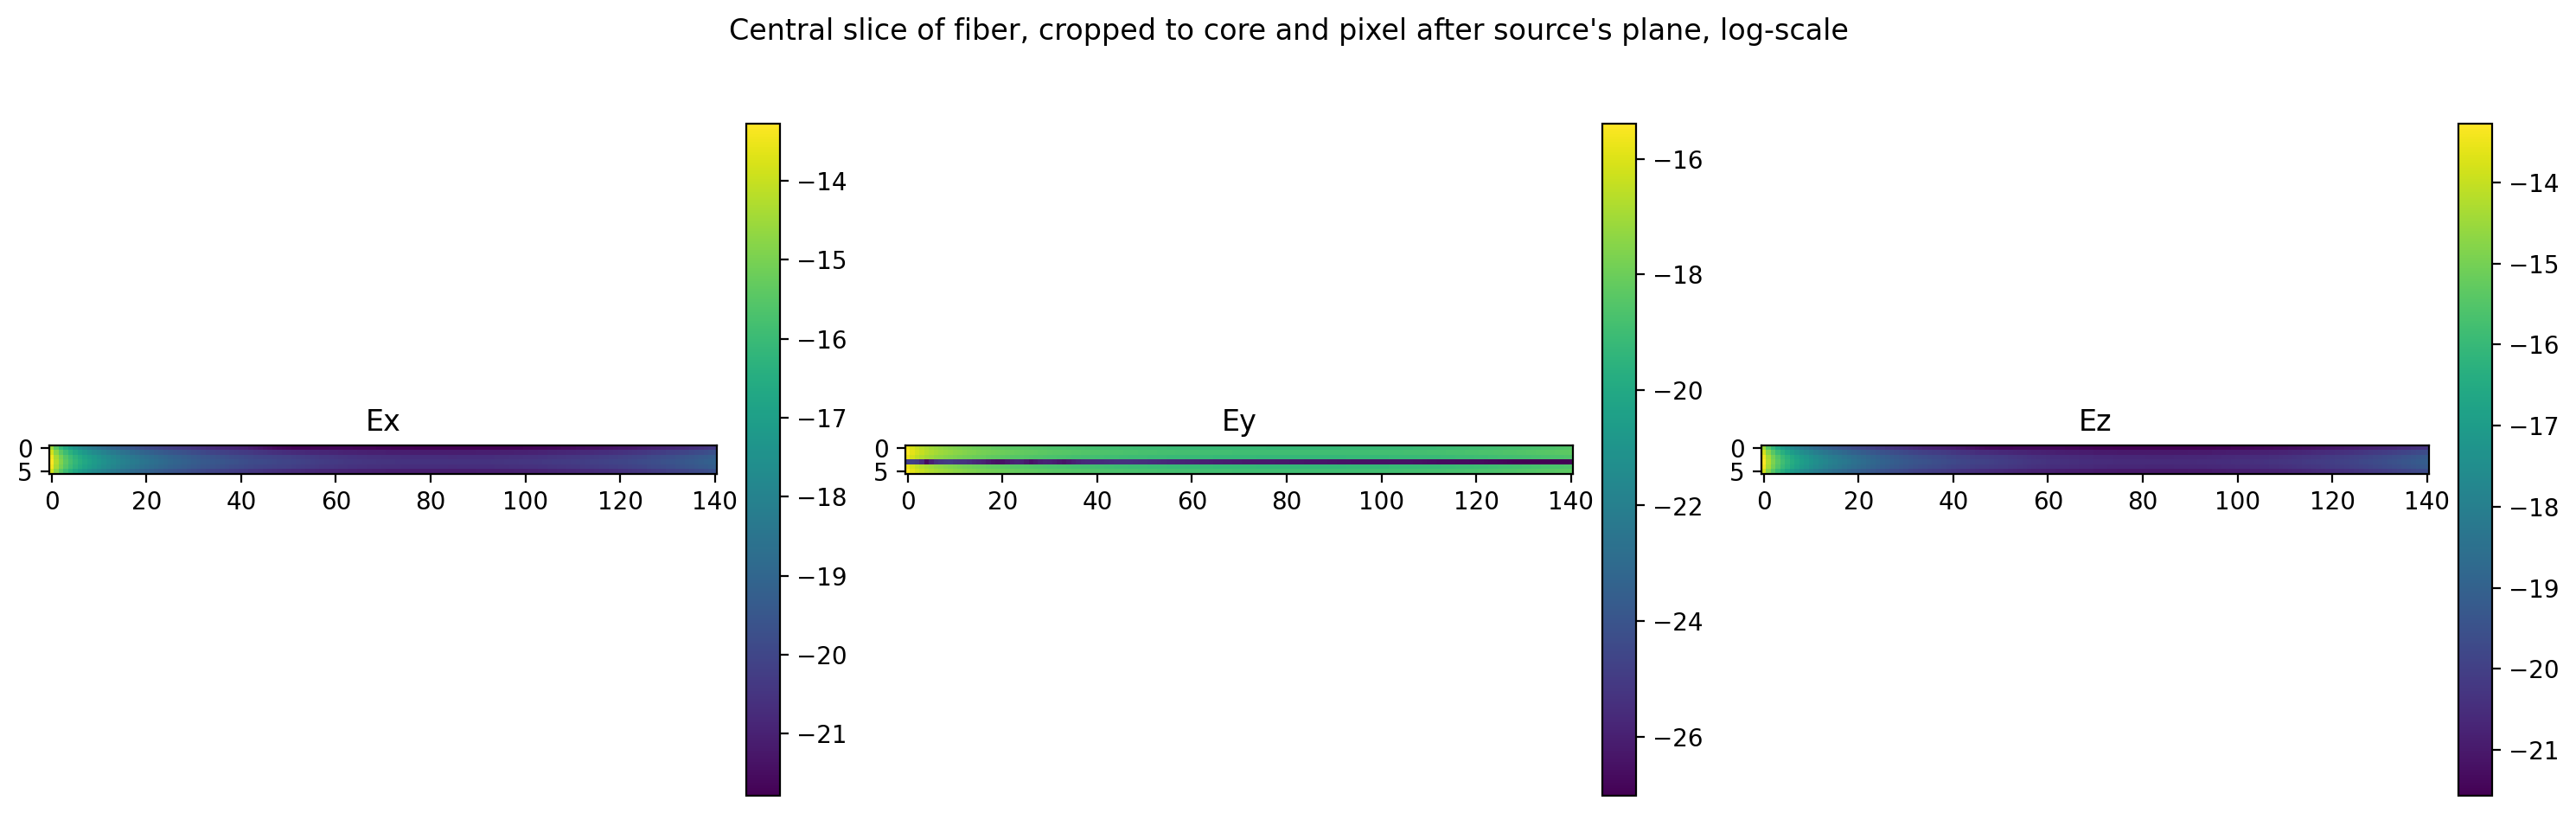

In [139]:
plt.figure(figsize=(15, 5), layout="tight")
hw = int(jnp.ceil(material_cylinder_radius_arr[0] * (sample.extent[0] / 2) / 2))


plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.log(
        jnp.abs(E)[
            grid_shape[0] // 2,
            source_pixel_index + 1 :,
            grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
            0,
        ].T
    )
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.log(
        jnp.abs(E)[
            grid_shape[0] // 2,
            source_pixel_index + 1 :,
            grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
            1,
        ].T
    )
)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.log(
        jnp.abs(E)[
            grid_shape[0] // 2,
            source_pixel_index + 1 :,
            grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
            2,
        ].T
    )
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle(
    "Central slice of fiber, cropped to core and pixel after source's plane, log-scale"
)

Text(0.5, 0.98, 'Central slice of fiber, cropped to core')

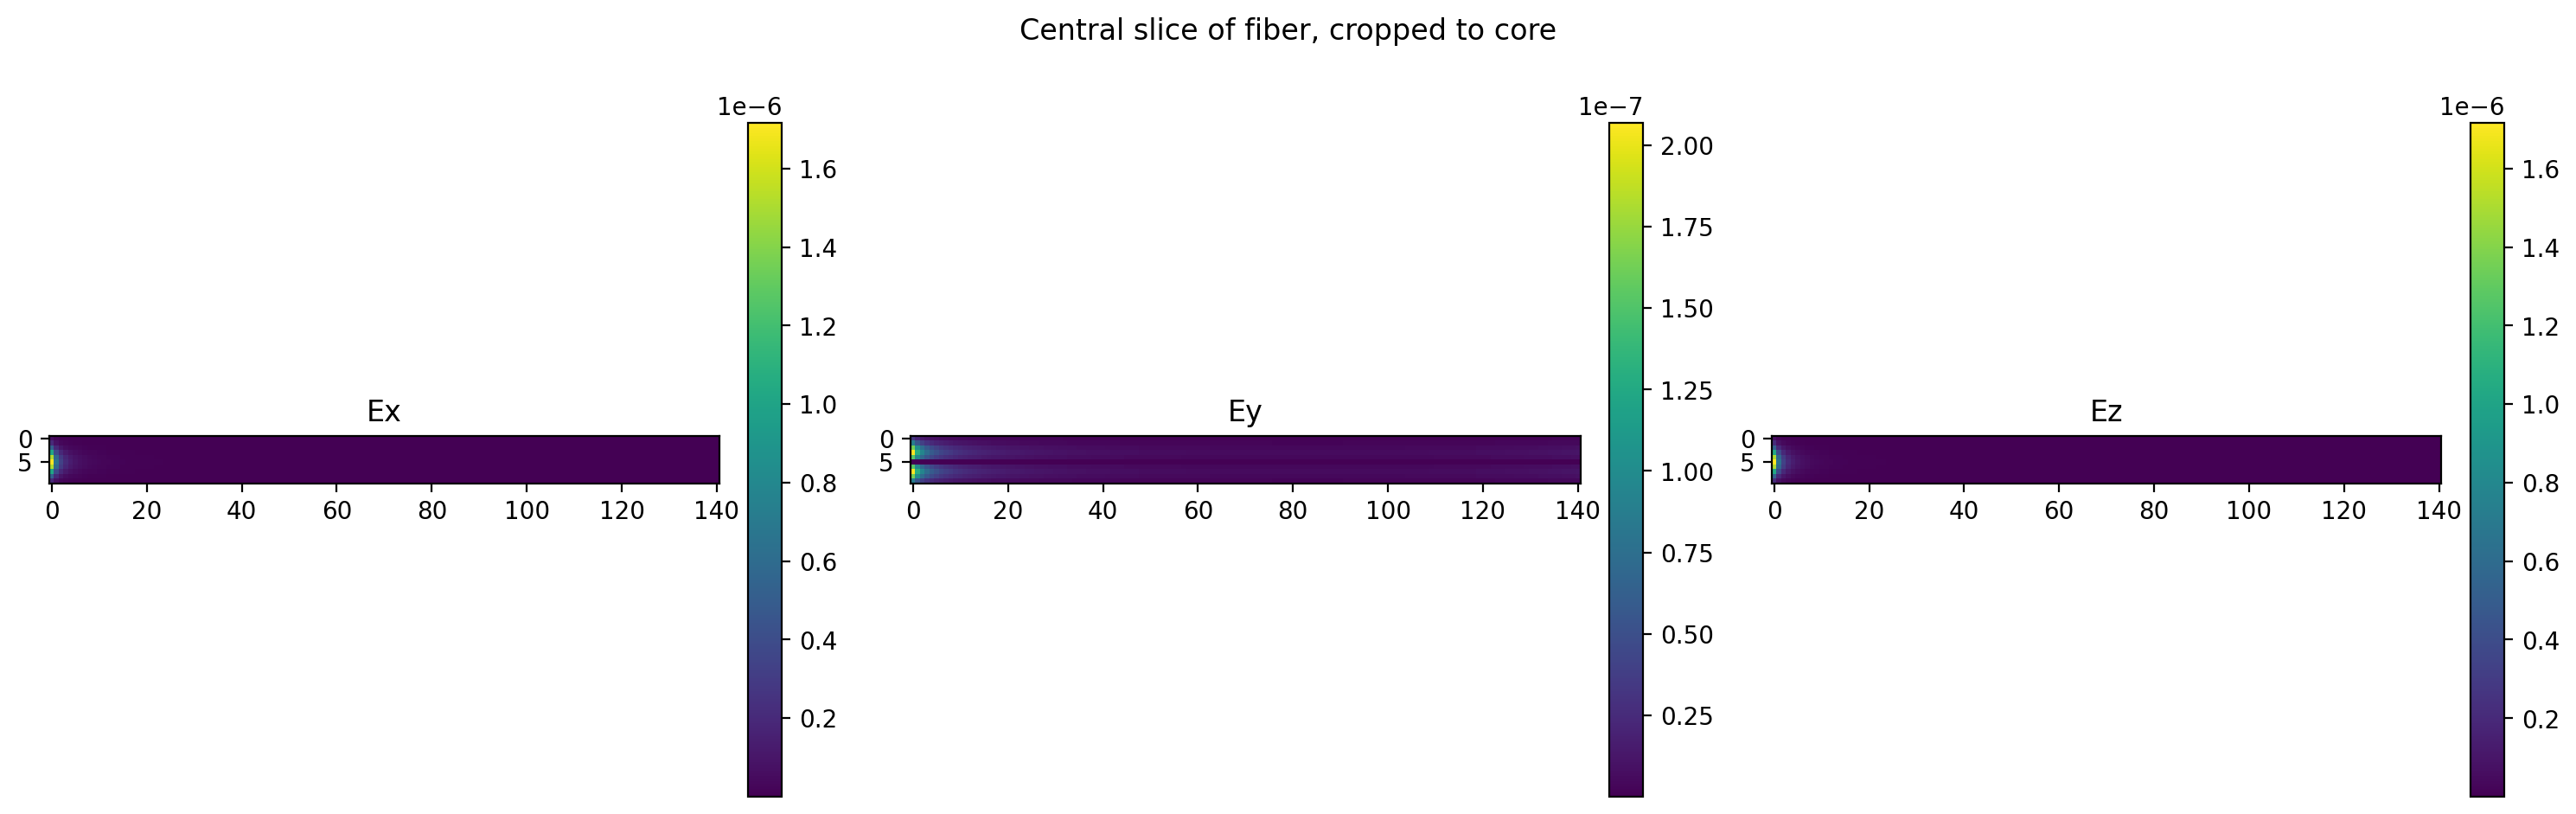

In [137]:
plt.figure(figsize=(15, 5), layout="tight")
hw = int(jnp.ceil(material_cylinder_radius_arr[1] * (sample.extent[0] / 2) / 2))

plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        0,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        1,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        2,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle("Central slice of fiber, cropped to cladding")

Text(0.5, 0.98, 'Central slice of fiber, cropped to core, log-scale')

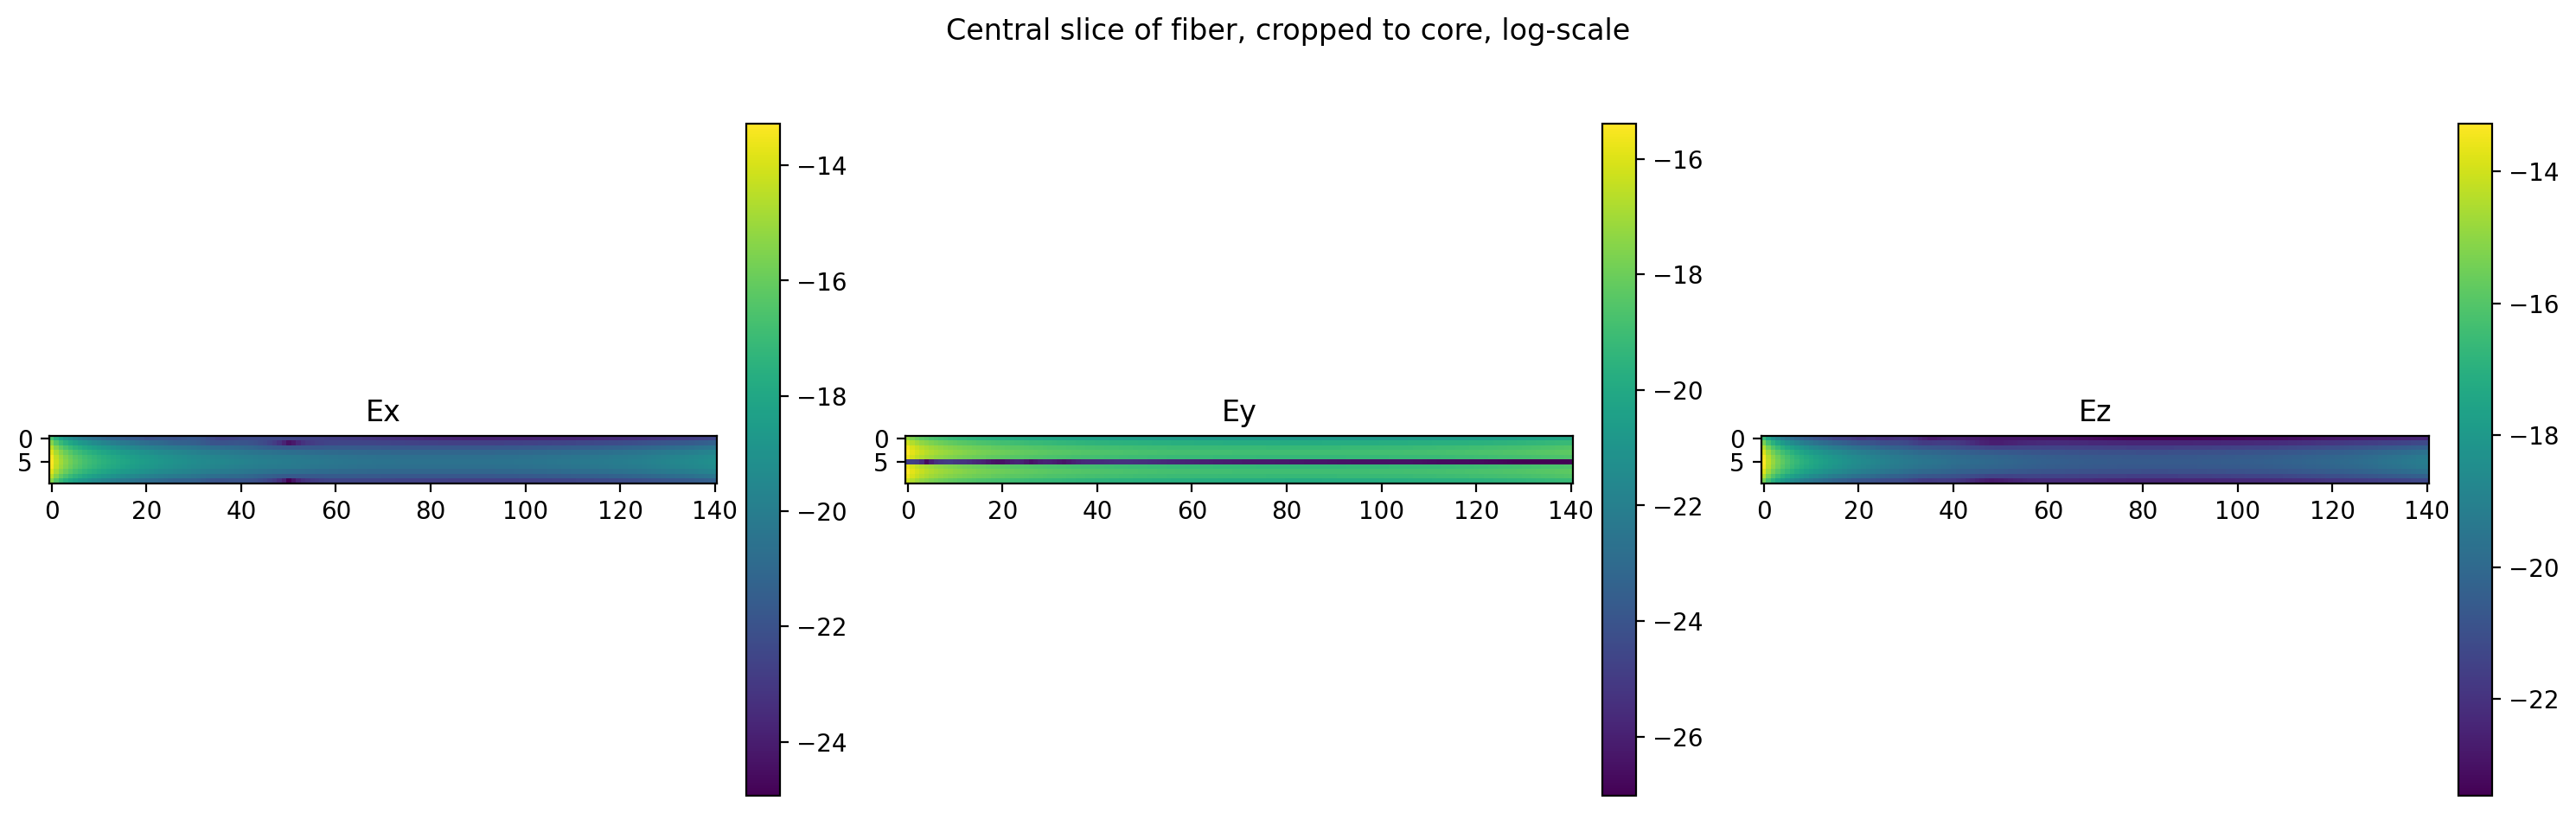

In [136]:
plt.figure(figsize=(15, 5), layout="tight")
hw = int(jnp.ceil(material_cylinder_radius_arr[1] * (sample.extent[0] / 2) / 2))

plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.log(
        jnp.abs(E)[
            grid_shape[0] // 2,
            source_pixel_index + 1 :,
            grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
            0,
        ].T
    )
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.log(
        jnp.abs(E)[
            grid_shape[0] // 2,
            source_pixel_index + 1 :,
            grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
            1,
        ].T
    )
)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.log(
        jnp.abs(E)[
            grid_shape[0] // 2,
            source_pixel_index + 1 :,
            grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
            2,
        ].T
    )
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle("Central slice of fiber, cropped to core, log-scale")

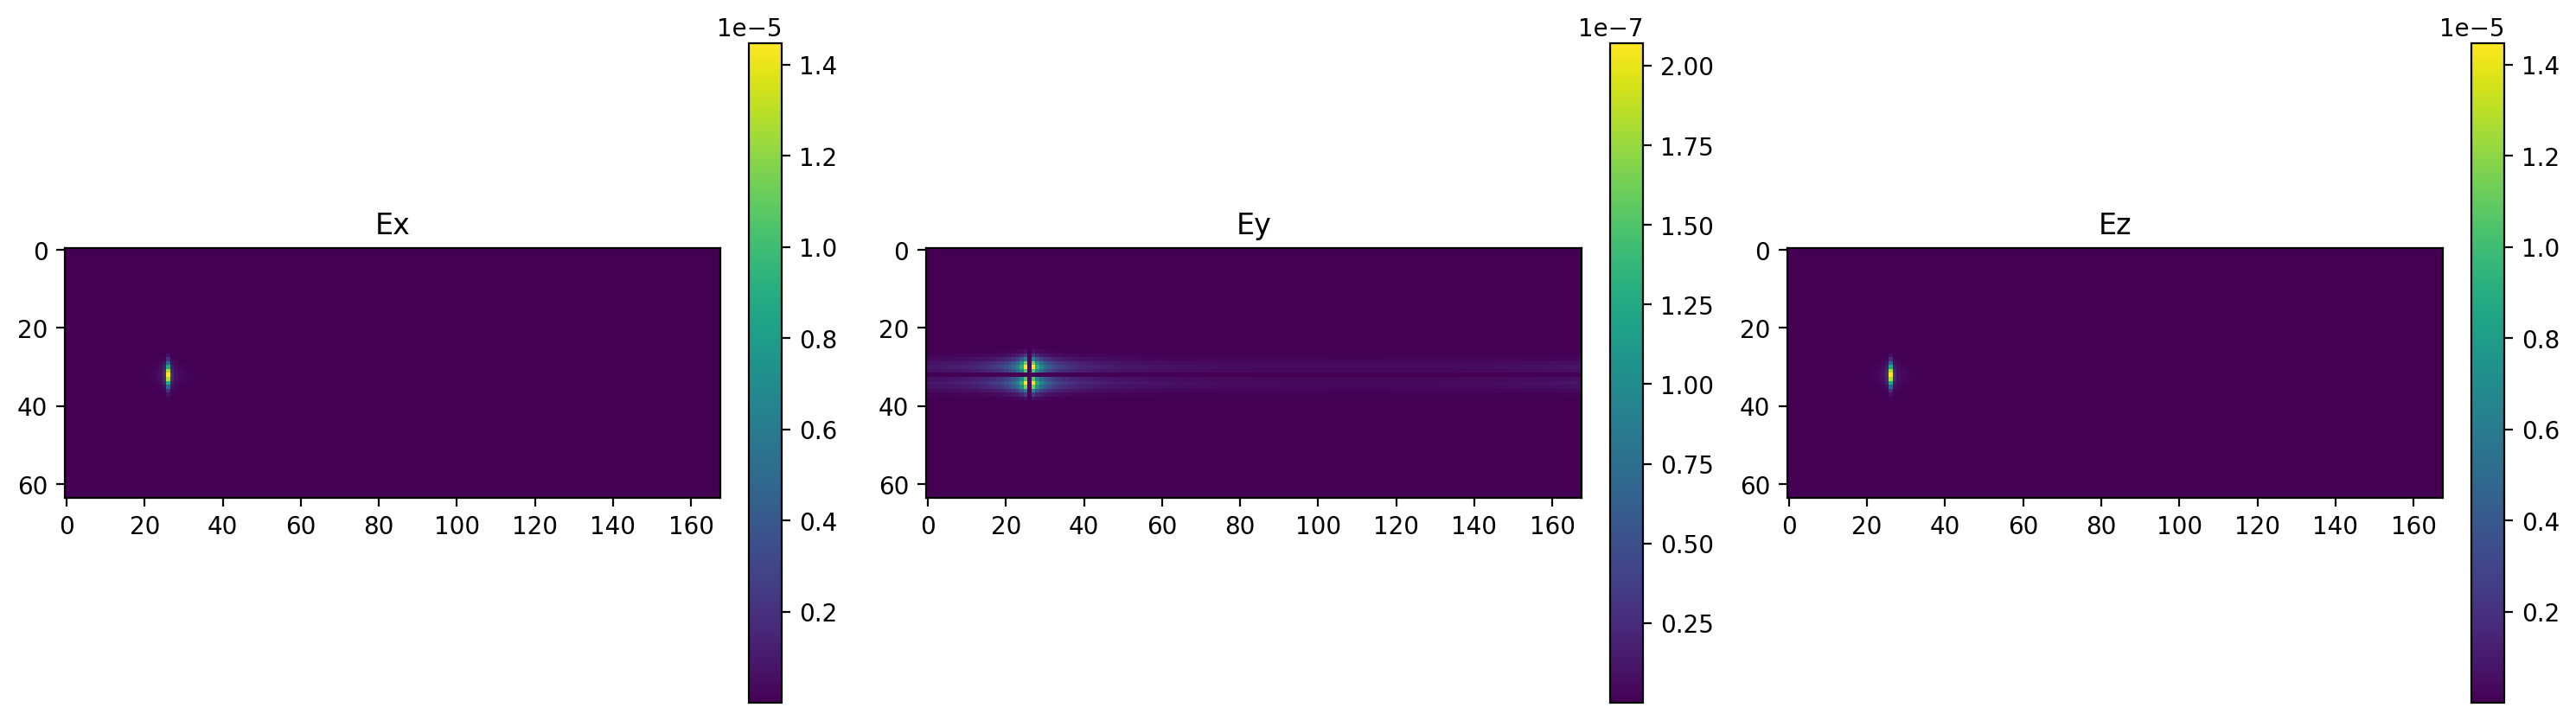

In [126]:
plt.figure(figsize=(15, 5), layout="tight")


plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.abs(E)[:, :, grid_shape[2] // 2, 0])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.abs(E)[:, :, grid_shape[2] // 2, 1])
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.abs(E)[:, :, grid_shape[2] // 2, 2])
plt.colorbar(fraction=0.046, pad=0.04)

Text(0.5, 0.98, 'log-scale full span')

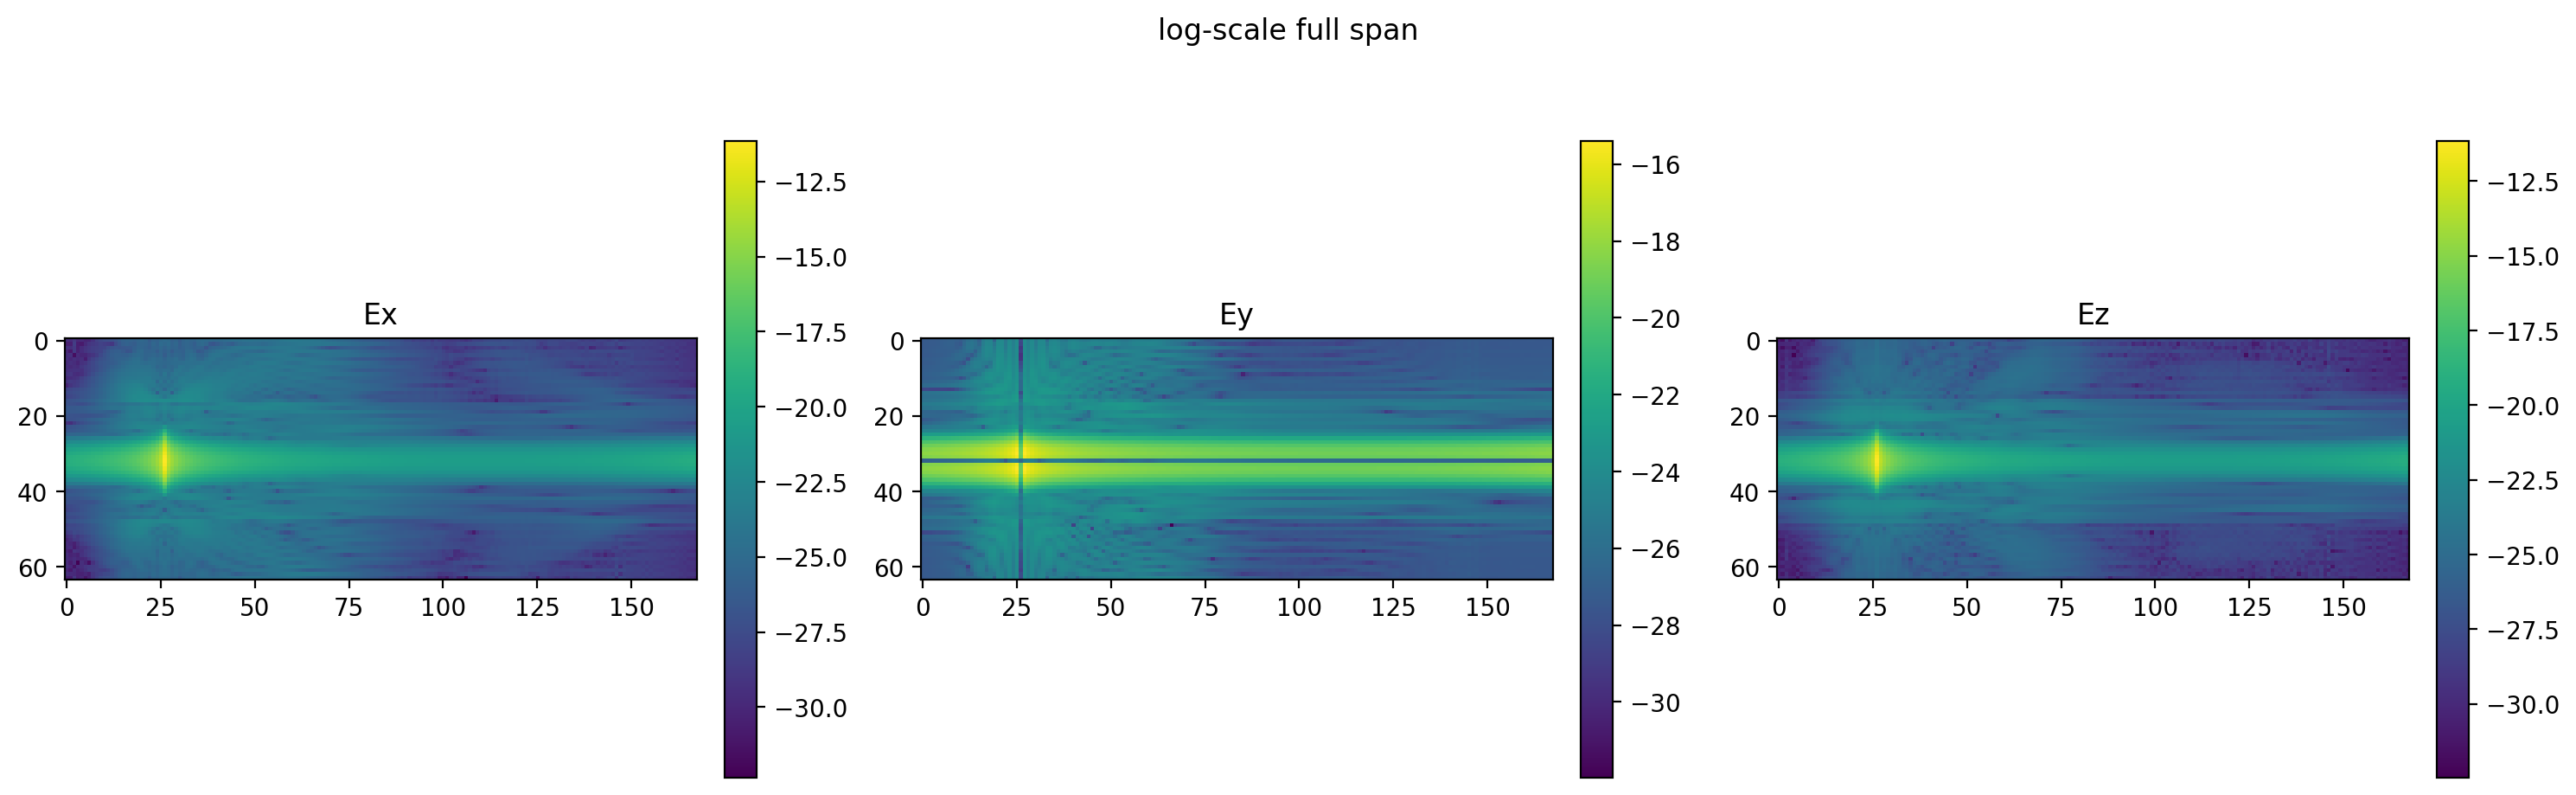

In [152]:
plt.figure(figsize=(15, 5), layout="tight")


plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.log(jnp.abs(E)[:, :, grid_shape[2] // 2, 0]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.log(jnp.abs(E)[:, :, grid_shape[2] // 2, 1]))
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.log(jnp.abs(E)[:, :, grid_shape[2] // 2, 2]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle("log-scale full span")

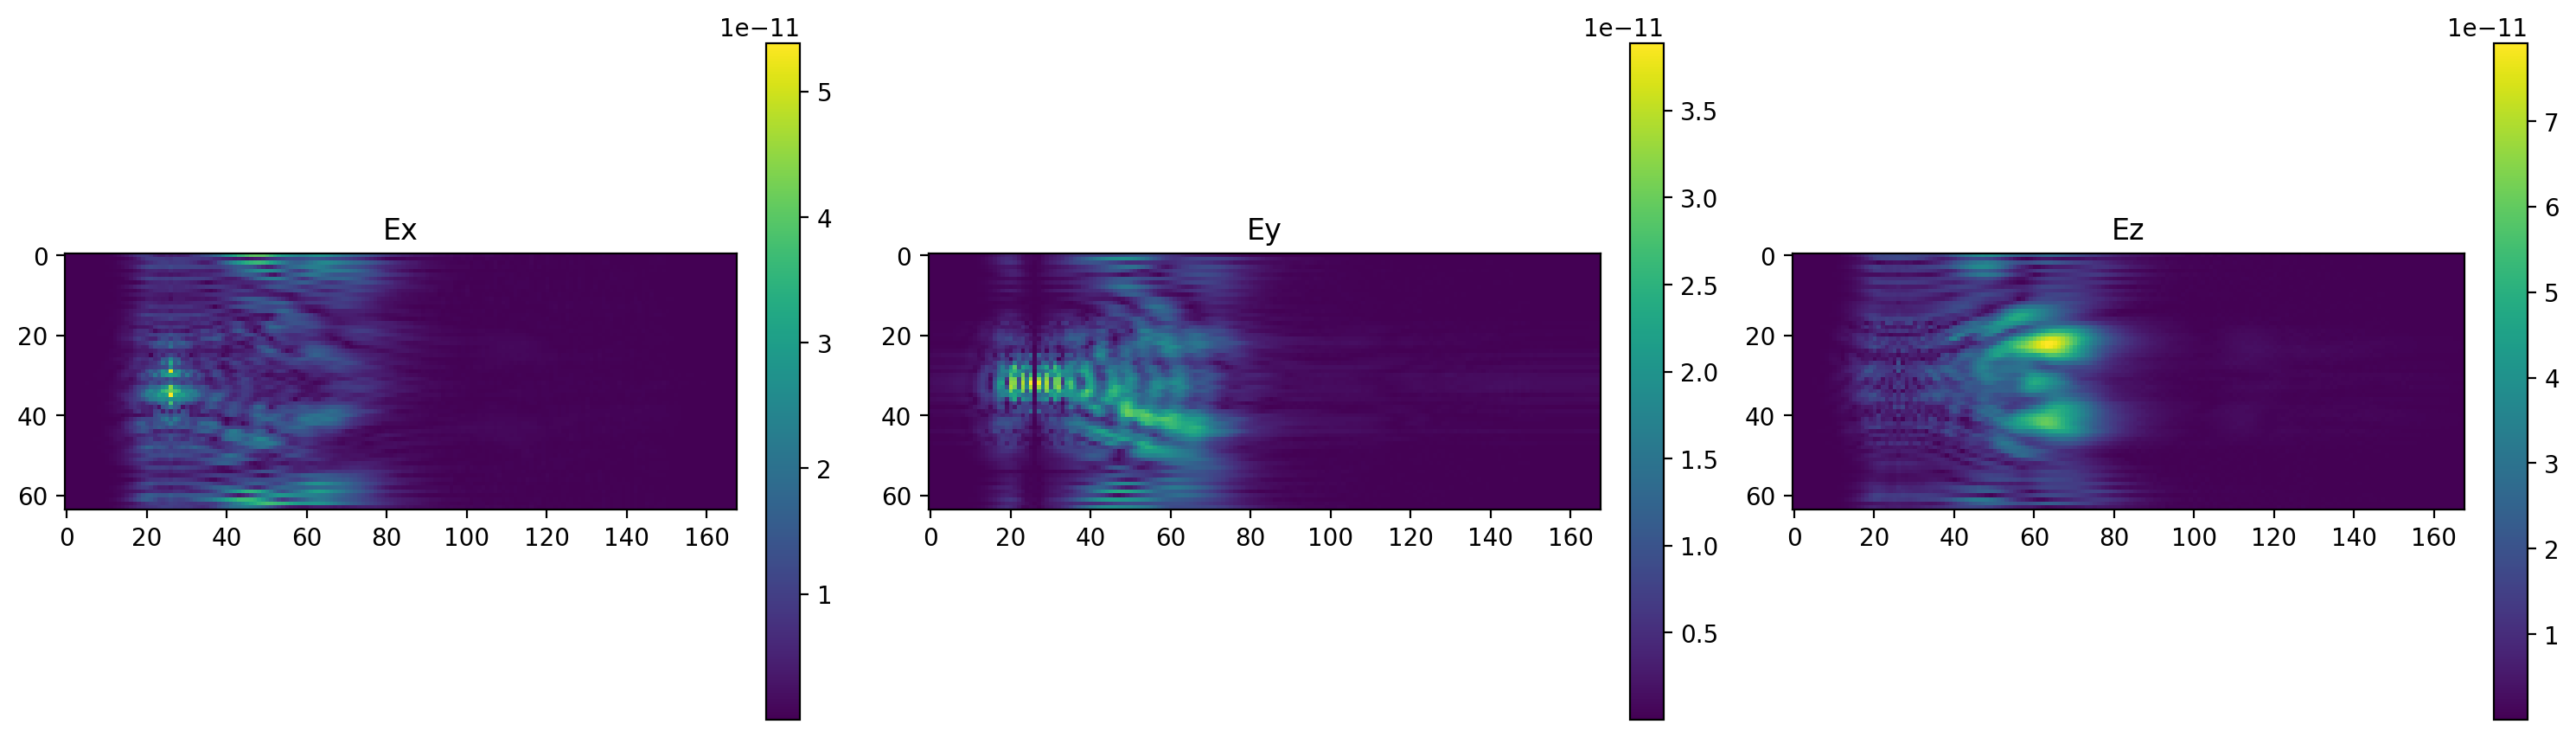

In [127]:
plt.figure(figsize=(15, 5), layout="tight")


plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.abs(E)[:, :, 0, 0])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.abs(E)[:, :, 0, 1])
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.abs(E)[:, :, 0, 2])
plt.colorbar(fraction=0.046, pad=0.04)

# Beam Modes setup
# TODO work on this
https://github.com/wavefrontshaping/article_MMF_disorder/blob/main/Generate_theoretical_modes/Generate_modes.ipynb

Parameters (update to match initial parameters above)

In [142]:
mode_NA = 0.2
mode_radius = 25  # in microns
mode_areaSize = (
    2.4 * mode_radius
)  # calculate the field on an area larger than the diameter of the fiber
n_points_modes = 256  # resolution of the window
mode_n1 = 1.45  # index of refraction at r=0 (maximum)
mode_wl = 1.55  # wavelength in microns
curvature = None
mode_k0 = 2.0 * jnp.pi / mode_wl

mode_r_max = 3.2 * mode_radius
npoints_search = 2**8
mode_dh = 2 * mode_radius / npoints_search

Methods

In [150]:
import pyMMF


def complex_correlation(Y1, Y2):
    Y1 = Y1 - Y1.mean()
    Y2 = Y2 - Y2.mean()
    return jnp.abs(jnp.sum(Y1.ravel() * Y2.ravel().conj())) / jnp.sqrt(
        jnp.sum(jnp.abs(Y1.ravel()) ** 2) * jnp.sum(jnp.abs(Y2.ravel()) ** 2)
    )


tr = lambda A, B: jnp.trace(jnp.abs(A @ B.transpose().conjugate()) ** 2)

fidelity = lambda A, B: tr(A, B) / (jnp.sqrt(tr(A, A) * tr(B, B)))


def get_modes(npoints):
    profile = pyMMF.IndexProfile(npoints=npoints, areaSize=mode_areaSize)
    profile.initParabolicGRIN(n1=mode_n1, a=mode_radius, NA=mode_NA)

    solver = pyMMF.propagationModeSolver()
    solver.setIndexProfile(profile)
    solver.setWL(mode_wl)
    modes = solver.solve(
        mode="radial",
        curvature=None,
        r_max=mode_r_max,  # max radius to calculate (and first try for large radial boundary condition)
        dh=mode_dh,  # radial resolution during the computation
        min_radius_bc=1.5,  # min large radial boundary condition
        change_bc_radius_step=0.95,  # change of the large radial boundary condition if fails
        N_beta_coarse=1000,  # number of steps of the initial coarse scan
        degenerate_mode="exp",
    )
    return modes

Generation

2025-05-28 17:25:44,448 - pyMMF.core [DEBUG  ]  Debug mode ON.
2025-05-28 17:25:44,462 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=0
2025-05-28 17:25:44,463 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2025-05-28 17:25:44,465 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2025-05-28 17:25:44,466 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2025-05-28 17:25:44,467 - pyMMF.solv [WARNING]  Retrying by changing r_max to 3.04a
2025-05-28 17:25:44,469 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2025-05-28 17:25:44,470 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2025-05-28 17:25:44,470 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.89a
2025-05-28 17:25:44,473 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
202

[[1.53422422e-07+0.j 1.35298684e-07+0.j 1.19376508e-07+0.j ...
  1.19376508e-07+0.j 1.35298684e-07+0.j 1.53422422e-07+0.j]
 [1.35298684e-07+0.j 1.19257716e-07+0.j 1.05171757e-07+0.j ...
  1.05171757e-07+0.j 1.19257716e-07+0.j 1.35298684e-07+0.j]
 [1.19376508e-07+0.j 1.05171757e-07+0.j 9.27040310e-08+0.j ...
  9.27040310e-08+0.j 1.05171757e-07+0.j 1.19376508e-07+0.j]
 ...
 [1.19376508e-07+0.j 1.05171757e-07+0.j 9.27040310e-08+0.j ...
  9.27040310e-08+0.j 1.05171757e-07+0.j 1.19376508e-07+0.j]
 [1.35298684e-07+0.j 1.19257716e-07+0.j 1.05171757e-07+0.j ...
  1.05171757e-07+0.j 1.19257716e-07+0.j 1.35298684e-07+0.j]
 [1.53422422e-07+0.j 1.35298684e-07+0.j 1.19376508e-07+0.j ...
  1.19376508e-07+0.j 1.35298684e-07+0.j 1.53422422e-07+0.j]]
[[-1.69126872e-08+1.69126872e-08j -1.49638709e-08+1.50821624e-08j
  -1.32455484e-08+1.34566328e-08j ...  1.32455484e-08+1.34566328e-08j
   1.49638709e-08+1.50821624e-08j  1.69126872e-08+1.69126872e-08j]
 [-1.50821624e-08+1.49638709e-08j -1.33389916e-08+1.3

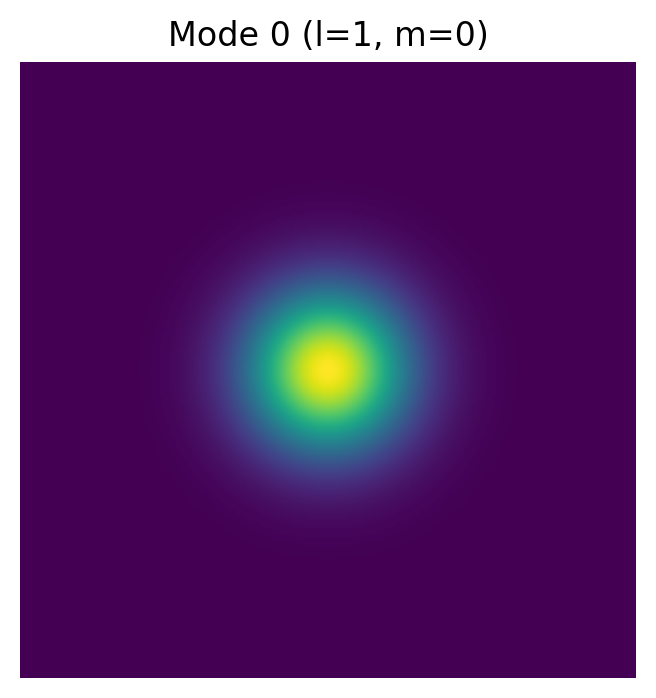

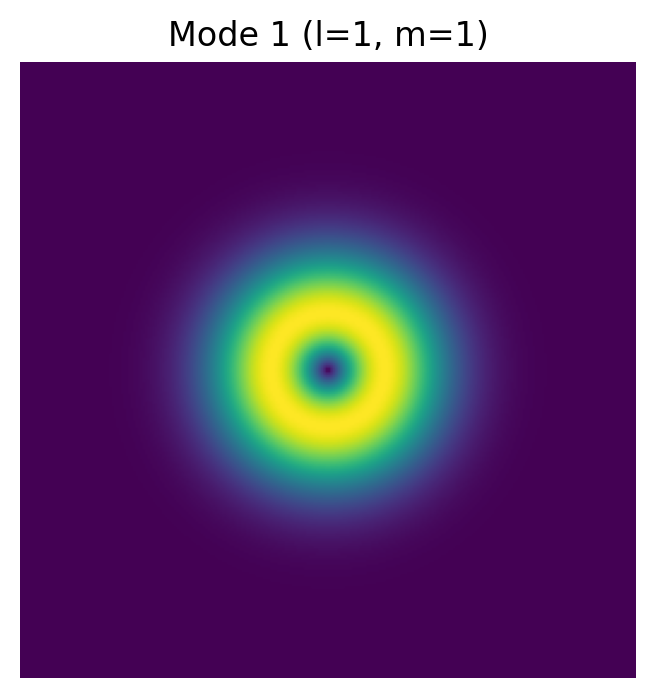

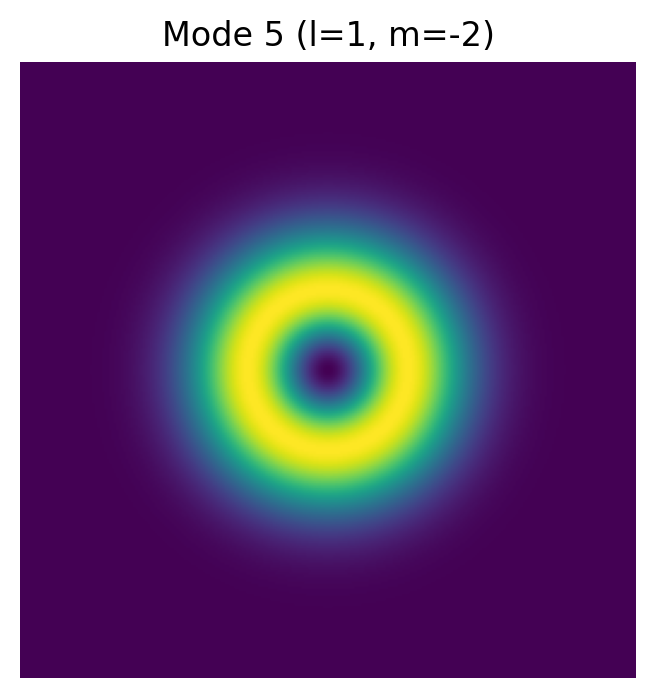

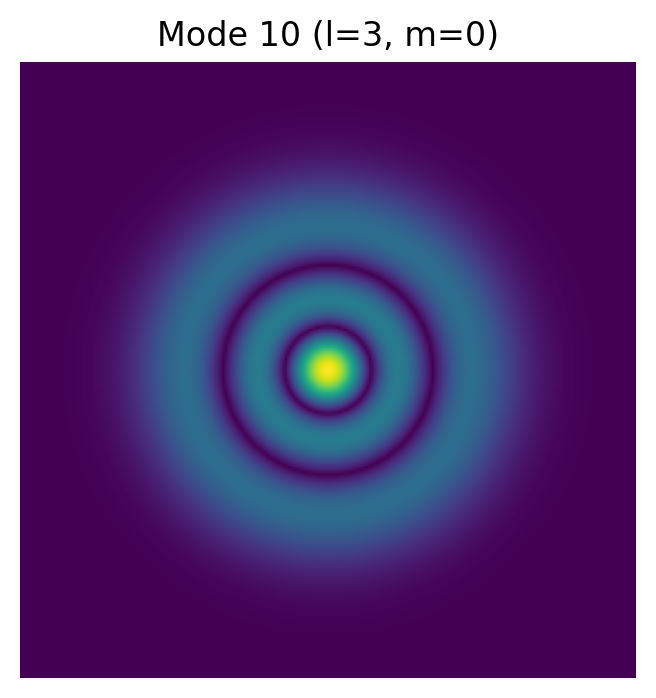

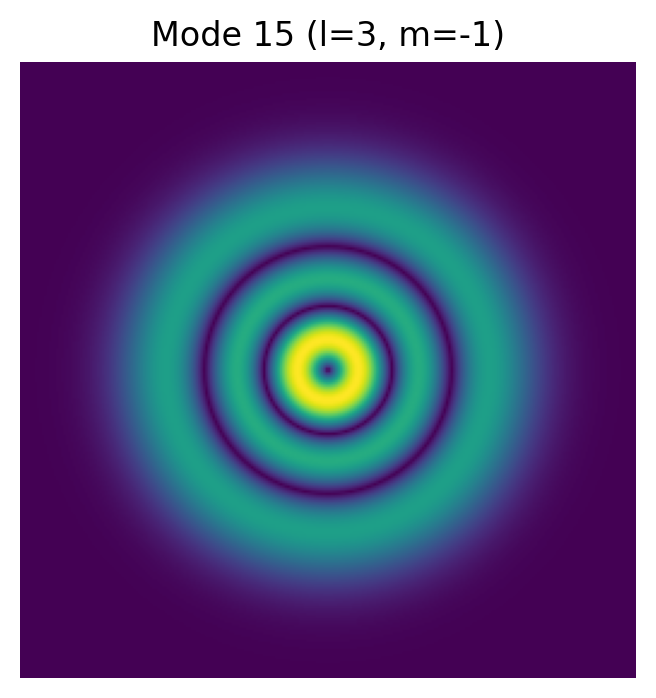

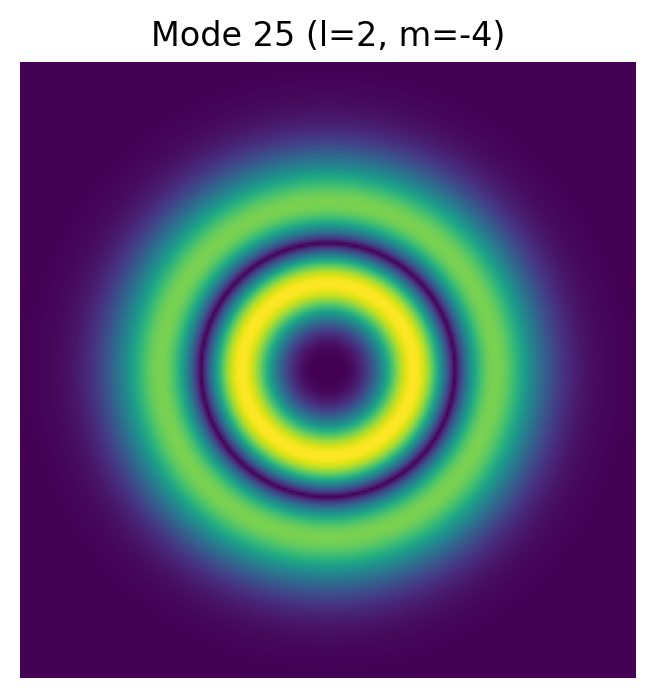

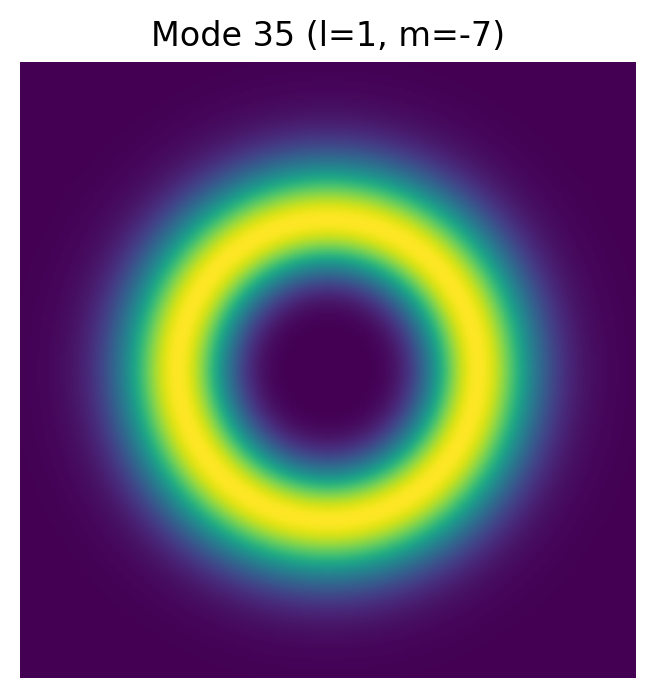

In [151]:
modes = get_modes(n_points_modes)
i_modes = [0, 1, 5, 10, 15, 25, 35]

M0 = modes.getModeMatrix()

for i in i_modes:
    Mi = M0[..., i]
    profile = Mi.reshape([n_points_modes] * 2)
    print(profile)
    plt.figure(figsize=(4, 4))
    plt.imshow(jnp.abs(profile))
    plt.axis("off")
    plt.title(f"Mode {i} (l={modes.l[i]}, m={modes.m[i]})")
    # save figure